In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets_tourism_dh import *

In [196]:
START_DATE = "2022-01-01"
END_DATE = "2024-03-31"

LOC_ID_COMUNE_MOLVENO = "27"
LOC_TYPE_COMUNE_MOLVENO = "TN_MKT_AL_3"

In [197]:
def mapping_tmax_val(tmax):
    if tmax>=28:
        return "Caldo"
    elif tmax<=22:
        return "Freddo"
    else:
        return "Normale"
def mapping_tmin_val(tmax):
    if tmax>=16:
        return "Caldo"
    elif tmax<=10:
        return "Freddo"
    else:
        return "Normale"

In [198]:
meteotrentino_bollettino_df

,data,comune,ambito,meteo,tmin,tmax,probprec06-12,intprec06-12,probtemp06-12,probprec12-18,intprec12-18,probtemp12-18
0,2018-03-03,BASELGA DI PINE',TRENTO,Molto nuvoloso,-4,2,molto bassa,debole,--,molto bassa,debole,--
1,2018-03-03,CANAZEI,MADONNA,Molto nuvoloso,-6,4,molto bassa,debole,--,molto bassa,debole,--
2,2018-03-03,CAVALESE,FIEMME,Molto nuvoloso,-4,3,molto bassa,debole,--,molto bassa,debole,--
3,2018-03-03,FOLGARIA,ALTIPIANO,Molto nuvoloso,-3,2,molto bassa,debole,--,molto bassa,debole,--
4,2018-03-03,FONDO,VALDINON,Molto nuvoloso,-4,3,molto bassa,debole,--,molto bassa,debole,--
...,...,...,...,...,...,...,...,...,...,...,...,...
41408,2024-05-31,COMANO TERME,GARDA,Coperto con piogge moderate,12,15,alta,forte,bassa,alta,moderata,bassa
41409,2024-05-31,BEZZECCA,GARDA,Coperto con piogge moderate,11,14,alta,forte,bassa,alta,moderata,bassa
41410,2024-05-31,PIEVE DI BONO,MADONNA,Coperto con piogge moderate,13,16,alta,forte,bassa,alta,moderata,bassa
41411,2024-05-31,CENTA SAN NICOLO,ALTIPIANO,Coperto con piogge moderate,11,14,alta,forte,bassa,alta,moderata,bassa


# Data preparation

In [199]:
vodafone_attendences_df

,date,locType,locId,userCountry,userProfile,userCluster,value
0,2022-01-01,AL_2,22,ALB,COMMUTER,None,0
1,2022-01-01,AL_2,22,ALB,TOURIST,None,862
2,2022-01-01,AL_2,22,ALB,VISITOR,None,44
3,2022-01-01,AL_2,22,AND,TOURIST,None,0
4,2022-01-01,AL_2,22,AND,VISITOR,None,0
...,...,...,...,...,...,...,...
4584498,2024-03-31,TN_MKT_POI,STAZ_TREN,SRB,VISITOR,UE,0
4584499,2024-03-31,TN_MKT_POI,STAZ_TREN,SWE,TOURIST,UE,0
4584500,2024-03-31,TN_MKT_POI,STAZ_TREN,SWE,VISITOR,UE,0
4584501,2024-03-31,TN_MKT_POI,STAZ_TREN,USA,TOURIST,None,0


In [200]:
attendences_df = vodafone_attendences_df[
    (vodafone_attendences_df['date'] >= START_DATE) &
    (vodafone_attendences_df['date'] <= END_DATE) &
    (vodafone_attendences_df["value"] != 0) &
    (vodafone_attendences_df["userProfile"] != 'INHABITANT') &
    (vodafone_attendences_df["userProfile"] != 'COMMUTER') &
    (vodafone_attendences_df["locId"] == LOC_ID_COMUNE_MOLVENO) &
    (vodafone_attendences_df["locType"] == LOC_TYPE_COMUNE_MOLVENO) ]
attendences_df = attendences_df[['date','userProfile','value']]
attendences_df['weekday'] = pd.to_datetime(attendences_df.date)
attendences_df['weekday2'] = pd.to_datetime(attendences_df.weekday).dt.weekday
attendences_df

,date,userProfile,value,weekday,weekday2
2343,2022-01-01,TOURIST,16,2022-01-01,5
2347,2022-01-01,TOURIST,16,2022-01-01,5
2359,2022-01-01,TOURIST,4393,2022-01-01,5
2360,2022-01-01,VISITOR,3130,2022-01-01,5
2367,2022-01-01,TOURIST,45,2022-01-01,5
...,...,...,...,...,...
4576319,2024-03-30,VISITOR,40,2024-03-30,5
4576328,2024-03-30,TOURIST,864,2024-03-30,5
4576329,2024-03-30,VISITOR,583,2024-03-30,5
4581539,2024-03-31,TOURIST,930,2024-03-31,6


In [201]:
########################################## Vodafone attendances
attendences_df = vodafone_attendences_df[
    (vodafone_attendences_df['date'] >= START_DATE) &
    (vodafone_attendences_df['date'] <= END_DATE) &
    (vodafone_attendences_df["value"] != 0) &
    (vodafone_attendences_df["userProfile"] != 'INHABITANT') &
    (vodafone_attendences_df["userProfile"] != 'COMMUTER') &
    (vodafone_attendences_df["locId"] == LOC_ID_COMUNE_MOLVENO) &
    (vodafone_attendences_df["locType"] == LOC_TYPE_COMUNE_MOLVENO) ]
attendences_df = attendences_df[['date','userProfile','value']]
attendences_df['weekday'] = pd.to_datetime(attendences_df.date).dt.weekday
attendences_df["is_weekend"] = attendences_df["weekday"].apply(lambda el: 1 if el==6 or el==5 else 0)
attendences_df['month'] = pd.to_datetime(attendences_df.date).dt.month
attendences_df['year'] = pd.to_datetime(attendences_df.date).dt.year

# tourists
tourist_attendences_df = attendences_df[attendences_df['userProfile'] == "TOURIST"][['date','value']].groupby('date').sum().reset_index()
tourist_attendences_df.rename(columns={"value": "presences_tourists"}, inplace=True)
tourist_attendences_df['weekday'] = pd.to_datetime(tourist_attendences_df.date).dt.weekday
tourist_attendences_df["is_weekend"] = tourist_attendences_df["weekday"].apply(lambda el: 1 if el==6 or el==5 else 0)
tourist_attendences_df['month'] = pd.to_datetime(tourist_attendences_df.date).dt.month
tourist_attendences_df['year'] = pd.to_datetime(tourist_attendences_df.date).dt.year
# excursionists
excursionist_attendences_df = attendences_df[attendences_df['userProfile'] == "VISITOR"][['date','value']].groupby('date').sum().reset_index()
excursionist_attendences_df.rename(columns={"value": "presences_excursionists"}, inplace=True)
excursionist_attendences_df['weekday'] = pd.to_datetime(excursionist_attendences_df.date).dt.weekday
excursionist_attendences_df["is_weekend"] = excursionist_attendences_df["weekday"].apply(lambda el: 1 if el==6 or el==5 else 0)
excursionist_attendences_df['month'] = pd.to_datetime(excursionist_attendences_df.date).dt.month
excursionist_attendences_df['year'] = pd.to_datetime(excursionist_attendences_df.date).dt.year

############################################# Weather in Molveno
meteo_df = meteotrentino_bollettino_df[
    (meteotrentino_bollettino_df["comune"].str.contains("MOLVENO")) &
    (meteotrentino_bollettino_df["data"] >= START_DATE) &
    (meteotrentino_bollettino_df["data"] <= END_DATE)
][['data', "tmax", "tmin", "probprec06-12", "probprec12-18"]]#.set_index('data')
meteo_df = meteo_df.rename(columns={"data": "date"})
meteo_df["tmax_group"] = meteo_df["tmax"].map(mapping_tmax_val)
meteo_df["tmin_group"] = meteo_df["tmin"].map(mapping_tmin_val)

############################################ Movimento turistico
#TODO

############################################  Merged dataset: Presences + Meteo
tourist_attendences_meteo_df = pd.merge(tourist_attendences_df, meteo_df,  how='outer').fillna(0)
excursionist_attendences_meteo_df = pd.merge(excursionist_attendences_df, meteo_df, how='outer').fillna(0)
tourist_attendences_meteo_df

,date,presences_tourists,weekday,is_weekend,month,year,tmax,tmin,probprec06-12,probprec12-18,tmax_group,tmin_group
0,2022-01-01,4550.0,5.0,1.0,1.0,2022.0,0.0,0.0,0,0,0,0
1,2022-01-02,5110.0,6.0,1.0,1.0,2022.0,0.0,0.0,0,0,0,0
2,2022-01-03,3643.0,0.0,0.0,1.0,2022.0,12.0,0.0,--,--,Freddo,Freddo
3,2022-01-04,3337.0,1.0,0.0,1.0,2022.0,0.0,0.0,0,0,0,0
4,2022-01-05,3255.0,2.0,0.0,1.0,2022.0,2.0,0.0,alta,bassa,Freddo,Freddo
...,...,...,...,...,...,...,...,...,...,...,...,...
813,2023-11-16,0.0,0.0,0.0,0.0,0.0,10.0,-1.0,--,--,Freddo,Freddo
814,2023-11-20,0.0,0.0,0.0,0.0,0.0,11.0,2.0,--,--,Freddo,Freddo
815,2023-11-21,0.0,0.0,0.0,0.0,0.0,7.0,3.0,--,--,Freddo,Freddo
816,2023-11-22,0.0,0.0,0.0,0.0,0.0,7.0,0.0,--,--,Freddo,Freddo


In [202]:
resulting_T_E["probprec06-12"].value_counts()

0              300
--             239
molto bassa    132
bassa           72
media           42
alta            33
Name: probprec06-12, dtype: int64

In [203]:
resulting_T_E = pd.concat([excursionist_attendences_meteo_df, tourist_attendences_meteo_df[["presences_tourists"]]], axis=1)
resulting_T_E["all"] = resulting_T_E["presences_tourists"].add(resulting_T_E["presences_excursionists"])
resulting_T_E = resulting_T_E[~resulting_T_E["presences_tourists"].isna()]
resulting_T_E[["presences_excursionists", "weekday", "month", "year", "tmax", "all"]] = resulting_T_E[["presences_excursionists", "weekday", "month", "year", "tmax", "all"]].astype("int")
resulting_T_E

,date,presences_excursionists,weekday,is_weekend,month,year,tmax,tmin,probprec06-12,probprec12-18,tmax_group,tmin_group,presences_tourists,all
0,2022-01-01,3130,5,1,1,2022,0,0.0,0,0,0,0,4550.0,7680
1,2022-01-02,2926,6,1,1,2022,0,0.0,0,0,0,0,5110.0,8036
2,2022-01-03,1757,0,0,1,2022,12,0.0,--,--,Freddo,Freddo,3643.0,5400
3,2022-01-04,1356,1,0,1,2022,0,0.0,0,0,0,0,3337.0,4693
4,2022-01-05,546,2,0,1,2022,2,0.0,alta,bassa,Freddo,Freddo,3255.0,3801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,2024-03-24,752,6,1,3,2024,10,-1.0,media,bassa,Freddo,Freddo,0.0,752
814,2024-03-25,325,0,0,3,2024,13,-3.0,molto bassa,molto bassa,Freddo,Freddo,0.0,325
815,2024-03-26,229,1,0,3,2024,0,0.0,0,0,0,0,0.0,229
816,2024-03-27,317,2,0,3,2024,11,7.0,alta,alta,Freddo,Freddo,0.0,317


In [204]:
resulting_T_E.dtypes

date                        object
presences_excursionists      int64
weekday                      int64
is_weekend                   int64
month                        int64
year                         int64
tmax                         int64
tmin                       float64
probprec06-12               object
probprec12-18               object
tmax_group                  object
tmin_group                  object
presences_tourists         float64
all                          int64
dtype: object

In [205]:
resulting_T_E["isweekend"] = resulting_T_E["weekday"].apply(lambda el: 1 if el==6 or el==5 else 0)
resulting_T_E[resulting_T_E["isweekend"]==0]

,date,presences_excursionists,weekday,is_weekend,month,year,tmax,tmin,probprec06-12,probprec12-18,tmax_group,tmin_group,presences_tourists,all,isweekend
2,2022-01-03,1757,0,0,1,2022,12,0.0,--,--,Freddo,Freddo,3643.0,5400,0
3,2022-01-04,1356,1,0,1,2022,0,0.0,0,0,0,0,3337.0,4693,0
4,2022-01-05,546,2,0,1,2022,2,0.0,alta,bassa,Freddo,Freddo,3255.0,3801,0
5,2022-01-06,2260,3,0,1,2022,0,0.0,0,0,0,0,3607.0,5867,0
6,2022-01-07,2201,4,0,1,2022,3,-5.0,--,--,Freddo,Freddo,3365.0,5566,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,2024-03-22,407,4,0,3,2024,16,-1.0,molto bassa,molto bassa,Freddo,Freddo,0.0,407,0
814,2024-03-25,325,0,0,3,2024,13,-3.0,molto bassa,molto bassa,Freddo,Freddo,0.0,325,0
815,2024-03-26,229,1,0,3,2024,0,0.0,0,0,0,0,0.0,229,0
816,2024-03-27,317,2,0,3,2024,11,7.0,alta,alta,Freddo,Freddo,0.0,317,0


<Axes: xlabel='date'>

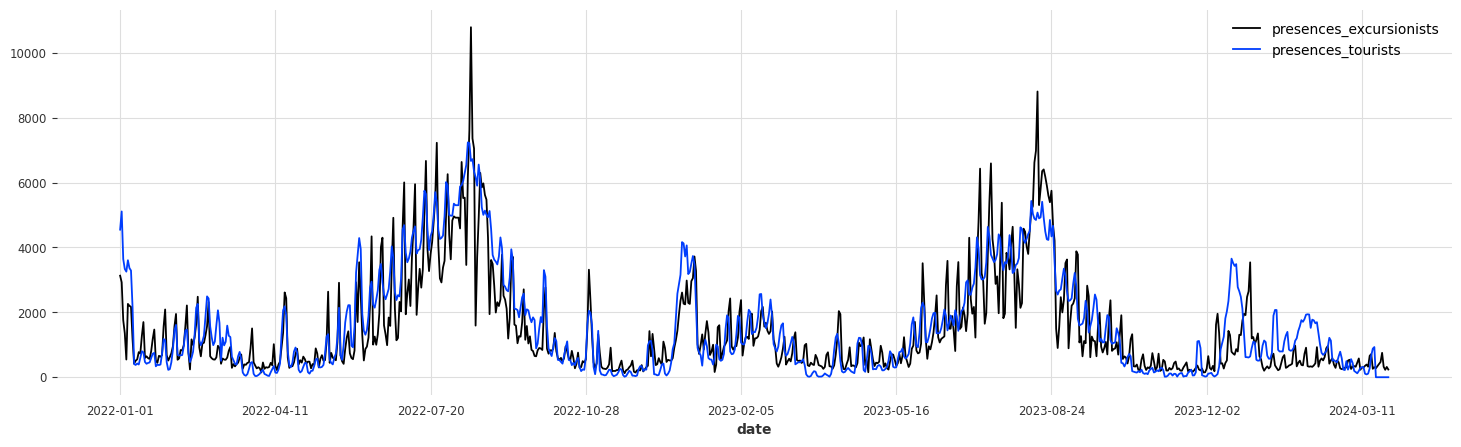

In [206]:
resulting_T_E[["date", "presences_excursionists", "presences_tourists"]].plot(x="date", figsize=(18, 5))

In [207]:
res

,index,date,presences_excursionists,weekday,is_weekend,month,year,tmax,tmin,probprec06-12,probprec12-18,tmax_group,tmin_group,presences_tourists,all,isweekend
0,0,2022-01-01,3130,5,1,1,2022,0,0.0,0,0,0,0,4550.0,7680,1
1,1,2022-01-02,2926,6,1,1,2022,0,0.0,0,0,0,0,5110.0,8036,1
2,2,2022-01-03,1757,0,0,1,2022,12,0.0,--,--,Freddo,Freddo,3643.0,5400,0
3,3,2022-01-04,1356,1,0,1,2022,0,0.0,0,0,0,0,3337.0,4693,0
4,4,2022-01-05,546,2,0,1,2022,2,0.0,alta,bassa,Freddo,Freddo,3255.0,3801,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,813,2024-03-24,752,6,1,3,2024,10,-1.0,media,bassa,Freddo,Freddo,0.0,752,1
814,814,2024-03-25,325,0,0,3,2024,13,-3.0,molto bassa,molto bassa,Freddo,Freddo,0.0,325,0
815,815,2024-03-26,229,1,0,3,2024,0,0.0,0,0,0,0,0.0,229,0
816,816,2024-03-27,317,2,0,3,2024,11,7.0,alta,alta,Freddo,Freddo,0.0,317,0


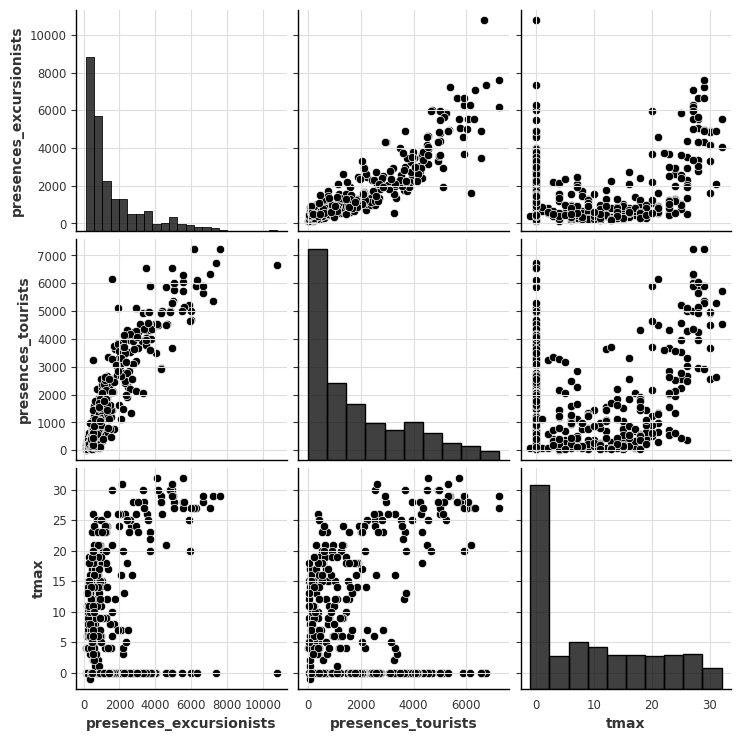

In [208]:
res = resulting_T_E.reset_index()
sns.pairplot(res[(res["date"] <= "2023-01-01") & (res["date"] <= "2023-12-31")][["presences_excursionists", "presences_tourists", "tmax"]])

# Statistical analysis

In [209]:
import statsmodels.api as sm

# Independent variables
resulting_T_E1 = resulting_T_E.reset_index()
resulting_T_E1["tmax"] = resulting_T_E1["tmax"].astype("int")
resulting_T_E1["tmin"] = resulting_T_E1["tmin"].astype("int")
X = resulting_T_E1[["presences_excursionists", "tmax", "tmin"]]

# Our dependent variable
y = resulting_T_E1.reset_index()[["presences_tourists"]]
# Add a constant to the independent value
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary statistics of the regression model
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     presences_tourists   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     799.5
Date:                Mon, 02 Dec 2024   Prob (F-statistic):          4.33e-242
Time:                        13:05:45   Log-Likelihood:                -6620.0
No. Observations:                 818   AIC:                         1.325e+04
Df Residuals:                     814   BIC:                         1.327e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

# Method 1: Stratification
This involves  breaking up our data into homogeneous strata or groups where the confounding factor is constant.

Example:Divide one year into seazons according to the attendances, approximation[(December, January, February), (March, April, May), (June, July, August), (September, October, Novembre)]


In [210]:
from itertools import combinations

season_groups = range(1, 13)
results = list(combinations(season_groups, 3))
#results

(29, 33)
(2, 3)
(7, 8)


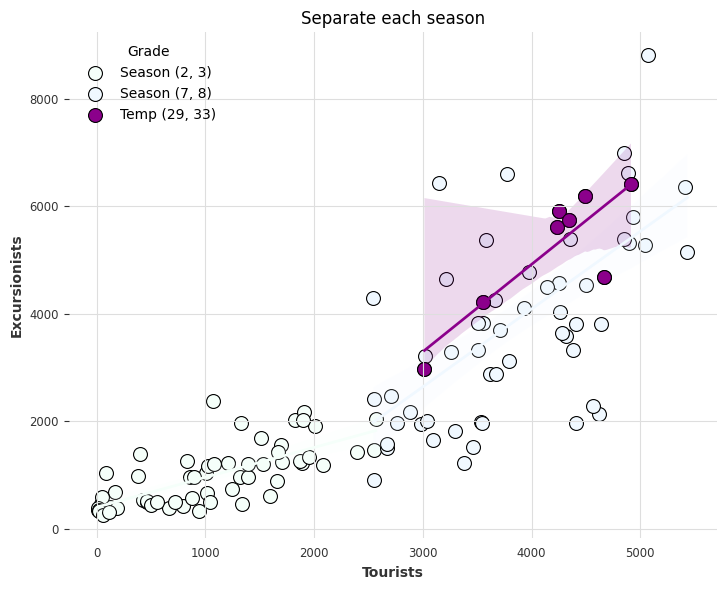

In [211]:
import matplotlib.colors as mcolors
import random

def season_granularity():
    pass

def temp_granularity():
    pass
    
def plot_seasons(year, 
                 season_groups=[(12, 1, 2), (3, 4, 5), (6, 7, 8), (9, 10, 11)],
                 temp_max_list=None
                 ):
    if year is not None:
        resulting_T_E_df = resulting_T_E[resulting_T_E["year"] == year]
    temp_dfs = []
    if temp_max_list is not None:
        for temp in temp_max_list:
            print(temp)            
            temp_dfs.append({"data": resulting_T_E_df[(resulting_T_E_df["tmax"] >= temp[0]) & (resulting_T_E_df["tmax"] <= temp[1])],
                             "temp": temp})
        #resulting_T_E_df = pd.concat(temp_dfs)
                     
    seasons_list = []
    for season in season_groups:
        print(season)
        seasons_list.append({"data": resulting_T_E_df[resulting_T_E_df['month'].isin(list(season))], 
                             "season": season})
    
    # Create the first plot (full dataset regression)
    plt.figure(figsize=(14, 6))    
    plt.subplot(1, 2, 2)  # Second plot
    #################### plot each season
    for season in seasons_list:
        color = random.choice(list(mcolors.CSS4_COLORS.keys()))
        sns.scatterplot(x='presences_tourists', y='presences_excursionists', data=season["data"], color=color, s=100, edgecolor='k', label=f'Season {season["season"]}')
        sns.regplot(x='presences_tourists', y='presences_excursionists', data=season["data"], scatter=False, color=color)

    for temp in temp_dfs:
        color = random.choice(list(mcolors.CSS4_COLORS.keys()))
        sns.scatterplot(x='presences_tourists', y='presences_excursionists', data=temp["data"], color=color, s=100, edgecolor='k', label=f'Temp {temp["temp"]}')
        sns.regplot(x='presences_tourists', y='presences_excursionists', data=temp["data"], scatter=False, color=color)
                    
    plt.title('Separate each season')
    plt.xlabel('Tourists')
    plt.ylabel('Excursionists')
    plt.legend(title='Grade')
    # Display the plots
    plt.tight_layout()
    plt.show()
plot_seasons(2023, season_groups=[(2, 3), (7,8)], 
             temp_max_list=[(29, 33)])

(12, 1, 2)
(3, 4, 5)
(6, 7, 8)
(9, 10, 11)


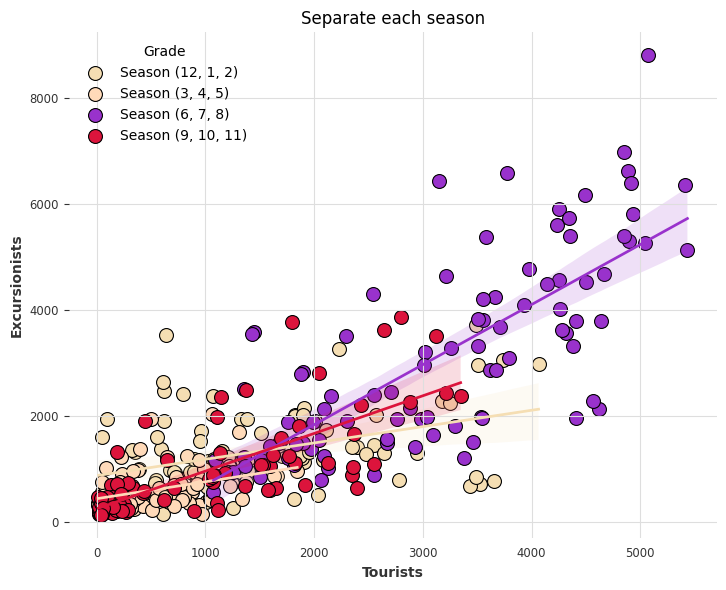

In [212]:
plot_seasons(2023)

(2, 3)
(7, 8)


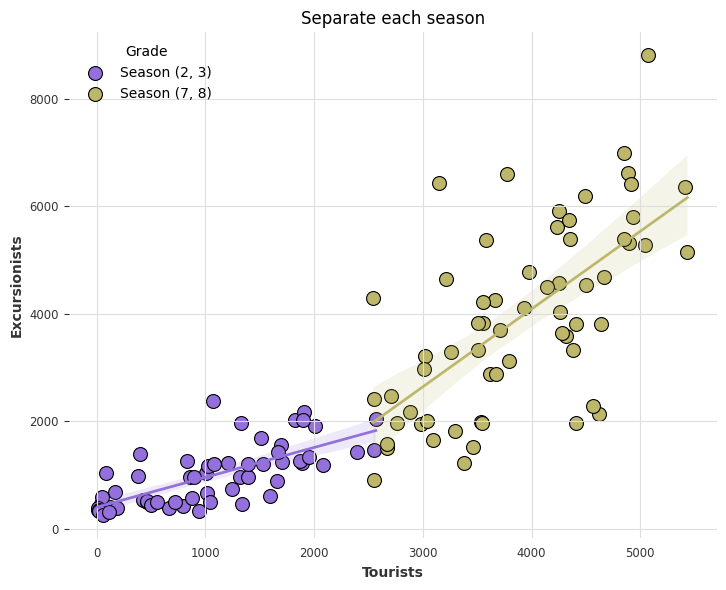

In [213]:
plot_seasons(2023, [(2, 3), (7,8)])

(1, 2, 3, 4)
(6, 7)
(8, 9)


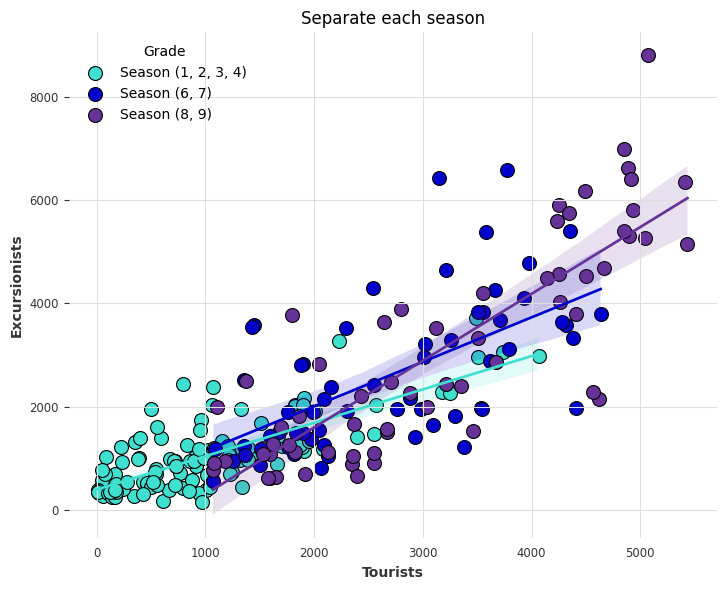

In [214]:
plot_seasons(2023, [(1,2,3,4), (6,7), (8,9)])

(12, 1, 2)
(3, 4, 5)
(6, 7, 8)
(9, 10, 11)


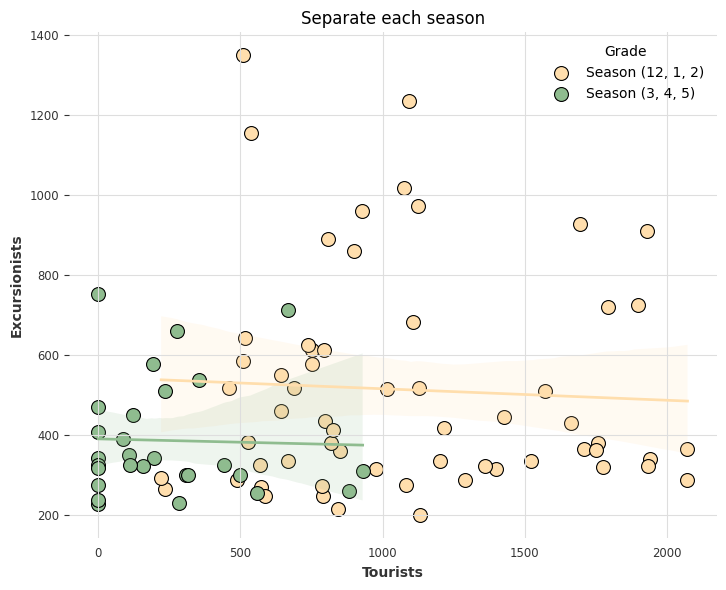

In [215]:
plot_seasons(2024)

# Method 2: Matching
In this method, for every entry in one group, you find a corresponding entry in the other group(s) that has the same or nearly the same value for the confounding variable(s). This method reduces the impact of confounding factors. Scikit-learn’s NearestNeighbors can be used to find matching pairs.

# Method 3: Multivariable analysis
You can use statistical methods that consider all variables at the same time. For instance, a regression analysis will allow you to see the effect of your independent variable on your dependent variable, while controlling for other variables. 
- libraries like statsmodels or scikit-learn to run multivariable regressions.

# Method 4: Propensity Score Matching (PSM)
This is a statistical matching technique that attempts to estimate the effect of a treatment, policy, or other intervention by accounting for the covariates that predict receiving the treatment. 
- causalinference and PyMatch are libraries that can be used to implement PSM

In [217]:
!pip -qq install pymatch causalinference

In [218]:
from pymatch.Matcher import Matcher
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from causalinference import CausalModel
from sklearn import preprocessing
from scipy import stats

In [219]:
# TODO standardize  - rescale the features

In [ ]:
control = df_ret[df_ret.trt1==0]
test = df_ret[df_ret.trt1==1]

#control = control.sample(200000)
m = Matcher(test,control,yvar='trt1',exclude=['usr_type'])

m.fit_scores(balance = True,nmodels = 100)  
m.predict_scores() 
m.plot_scores()

plt.show()

# Method 5: Instrumental Variable (IV) methods
An IV is a variable that is used in regression analysis when the model has endogeneity issues, such as measurement error, omitted variables, or simultaneity. It serves as a tool for providing consistent estimates of parameters. You can use the linearmodels library in Python for this approach.

In [116]:
import numpy as np
from statsmodels.datasets import grunfeld
data = grunfeld.load_pandas().data
data.year = data.year.astype(np.int64)
# MultiIndex, entity - time
data = data.set_index(['firm','year'])
from linearmodels import PanelOLS
mod = PanelOLS(data.invest, data[['value','capital']], entity_effects=True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
res

Dep. Variable:,invest,R-squared:,0.7667
Estimator:,PanelOLS,R-squared (Between):,0.8223
No. Observations:,220,R-squared (Within):,0.7667
Date:,"Wed, Nov 20 2024",R-squared (Overall):,0.8132
Time:,15:47:30,Log-likelihood,-1167.4
Cov. Estimator:,Clustered,,
,,F-statistic:,340.08
Entities:,11,P-value,0.0000
Avg Obs:,20.000,Distribution:,"F(2,207)"
Min Obs:,20.000,,
Max Obs:,20.000,F-statistic (robust):,31.490


In [220]:
resulting_T_E

,date,presences_excursionists,weekday,is_weekend,month,year,tmax,tmin,probprec06-12,probprec12-18,tmax_group,tmin_group,presences_tourists,all,isweekend
0,2022-01-01,3130,5,1,1,2022,0,0.0,0,0,0,0,4550.0,7680,1
1,2022-01-02,2926,6,1,1,2022,0,0.0,0,0,0,0,5110.0,8036,1
2,2022-01-03,1757,0,0,1,2022,12,0.0,--,--,Freddo,Freddo,3643.0,5400,0
3,2022-01-04,1356,1,0,1,2022,0,0.0,0,0,0,0,3337.0,4693,0
4,2022-01-05,546,2,0,1,2022,2,0.0,alta,bassa,Freddo,Freddo,3255.0,3801,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,2024-03-24,752,6,1,3,2024,10,-1.0,media,bassa,Freddo,Freddo,0.0,752,1
814,2024-03-25,325,0,0,3,2024,13,-3.0,molto bassa,molto bassa,Freddo,Freddo,0.0,325,0
815,2024-03-26,229,1,0,3,2024,0,0.0,0,0,0,0,0.0,229,0
816,2024-03-27,317,2,0,3,2024,11,7.0,alta,alta,Freddo,Freddo,0.0,317,0


# Model for Excursionists

In [221]:
resulting_T_E = resulting_T_E.reset_index(drop=True)

In [222]:
training_data_T_E = resulting_T_E[["presences_excursionists", "is_weekend", "month", "year", "tmax", "tmin"]]
training_data_T_E = training_data_T_E.astype("int")
training_data_T_E.head()

,presences_excursionists,is_weekend,month,year,tmax,tmin
0,3130,1,1,2022,0,0
1,2926,1,1,2022,0,0
2,1757,0,1,2022,12,0
3,1356,0,1,2022,0,0
4,546,0,1,2022,2,0


In [223]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import f_regression

In [224]:
features = ['is_weekend', 'month', 'tmax', 'year', 'tmin']
target = ["presences_excursionists"]

In [225]:
models_metrics = []

In [226]:
class PCAConfig:
    def __init__(self, is_pca_enabled, num_components):
        self._is_pca_enabled = is_pca_enabled
        self._num_components = num_components   
        
    def is_enabled(self):
        return self._is_pca_enabled
        
    def get_nr_components(self):
        return self._num_components
    

In [227]:
X = training_data_T_E.loc[:, features].values
y = training_data_T_E.loc[:, target].values
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=0)

def define_baseline_regressor(training_data_T_E, features, target, pca_config, name="baseline model excursionist"):
    # Step 1: Train test split
    X = training_data_T_E.loc[:, features].values
    y = training_data_T_E.loc[:, target].values
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=0)
    
    # Step 2: Standardization
    std_scaler = StandardScaler()
    X_train = std_scaler.fit_transform(X_train)
    X_test = std_scaler.transform(X_test)
    
    # Step 3: Apply PCA transformation
    if pca_config.is_enabled():
        pca = PCA(n_components=pca_config.get_nr_components())
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        print(f"PCA Explained variance : {pca.explained_variance_ratio_}")

        
    # Step 4: Fitting Linear Regression to the training set
    linear_regressor = LinearRegression()
    linear_regressor.fit(X_train, y_train)
        
    # Step 5: Prediction and accuracy evaluation
    y_predictions = linear_regressor.predict(X_test)
    r2 = r2_score(y_test, y_predictions)
    rmse = np.sqrt(mean_squared_error(y_test, y_predictions))
    mae = mean_absolute_error(y_test, y_predictions)
    print(f"Model Evaluation Metrics: r2_score: {r2},  root mean squared error: {rmse}, mean absolute error: {mae}")
    models_metrics.append({"name": name, "r2_score": r2, "rmse": rmse, "mae": mae})
    return linear_regressor
    
pca_config = PCAConfig(True, 4)
linear_regressor = define_baseline_regressor(training_data_T_E, features, target, pca_config)

PCA Explained variance : [0.39555529 0.22942638 0.19764093 0.14641112]
Model Evaluation Metrics: r2_score: 0.22269405550653876,  root mean squared error: 1331.1208429658718, mean absolute error: 959.516800794908


In [228]:
f_statistic, p_values = f_regression(X_train, y_train)
f_statistic, p_values

(array([ 39.78841111,  10.70602761,  76.87171722,  14.0958866 ,
        119.75907857]),
 array([5.22288418e-10, 1.12419867e-03, 1.57793510e-17, 1.89241319e-04,
        1.05041240e-25]))

In [229]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator= linear_regressor , step = 1) 
fit = rfe.fit(X_train, y_train)
# It uses the model accuracy to identify which features (and combination of features) contribute the most to predicting the target variable.

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)
feature_importance_df = pd.DataFrame({"Feature": list(features), "Rank":fit.ranking_})
feature_importance_df.sort_values(by="Rank")

Num Features: 2
Selected Features: [ True False False  True False]
Feature Ranking: [1 4 3 1 2]


,Feature,Rank
0,is_weekend,1
3,year,1
4,tmin,2
2,tmax,3
1,month,4


In [230]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fitting the model with the transformed data according to their importance
lr_rfe_model = linear_regressor.fit(X_train_rfe, y_train)

y_predictions_rfe = lr_rfe_model.predict(X_test_rfe)
r2 = r2_score(y_test, y_predictions_rfe)
rmse = np.sqrt(mean_squared_error(y_test, y_predictions_rfe))
mae = mean_absolute_error(y_test, y_predictions_rfe)
print(f"Model Evaluation Metrics: r2_score: {r2},  root mean squared error: {rmse}, mean absolute error: {mae}")
models_metrics.append({"name": "rfe_regressor", "r2_score": r2, "rmse": rmse, "mae": mae})

Model Evaluation Metrics: r2_score: 0.09225345383753569,  root mean squared error: 1438.4798801368545, mean absolute error: 1013.380653568728


In [231]:
models_metrics_df = pd.DataFrame(columns=["name", "r2_score", "rmse", "mae"], data=models_metrics)
models_metrics_df

,name,r2_score,rmse,mae
0,baseline model excursionist,0.222694,1331.120843,959.516801
1,rfe_regressor,0.092253,1438.479880,1013.380654


In [232]:
def define_boruta_regressor(training_data_T_E, features, target, pca_config):
    # Step 1: Train test split
    X = training_data_T_E.loc[:, features].values
    y = training_data_T_E.loc[:, target].values
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=0)
    
    # Step 2: Standardization
    std_scaler = StandardScaler()
    X_train = std_scaler.fit_transform(X_train)
    X_test = std_scaler.transform(X_test)
    
    # Step 3: Apply PCA transformation
    if pca_config.is_enabled():
        pca = PCA(n_components=pca_config.get_nr_components())
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        print(f"PCA Explained variance : {pca.explained_variance_ratio_}")

        
    # Step 4: Fitting Linear Regression to the training set
    linear_regressor = LinearRegression()
    linear_regressor.fit(X_train, y_train)
        
    # Step 5: Prediction and accuracy evaluation
    y_predictions = linear_regressor.predict(X_test)
    r2 = r2_score(y_test, y_predictions)
    rmse = np.sqrt(mean_squared_error(y_test, y_predictions))
    mae = mean_absolute_error(y_test, y_predictions)
    print(f"Model Evaluation Metrics: r2_score: {r2},  root mean squared error: {rmse}, mean absolute error: {mae}")

pca_config = PCAConfig(True, 4)
define_baseline_regressor(training_data_T_E, features, target, pca_config)

PCA Explained variance : [0.39555529 0.22942638 0.19764093 0.14641112]
Model Evaluation Metrics: r2_score: 0.22269405550653876,  root mean squared error: 1331.1208429658718, mean absolute error: 959.516800794908


LinearRegression()

Feature Importance / Selection
- RFE (Recursive Feature Elimination)
- Boruta
- RandomForestClassifier
- XGBoost

# Model for Tourists

In [233]:
training_data_T_E = resulting_T_E[["presences_tourists", "is_weekend", "month", "year", "tmax", "tmin"]]
training_data_T_E = training_data_T_E[~training_data_T_E["presences_tourists"].isna()]
training_data_T_E = training_data_T_E.astype("int")
training_data_T_E.head()

,presences_tourists,is_weekend,month,year,tmax,tmin
0,4550,1,1,2022,0,0
1,5110,1,1,2022,0,0
2,3643,0,1,2022,12,0
3,3337,0,1,2022,0,0
4,3255,0,1,2022,2,0


In [234]:
features = ['is_weekend', 'month', 'tmax', 'year', 'tmin']
target = ["presences_tourists"]
pca_config = PCAConfig(True, 4)
linear_regressor = define_baseline_regressor(training_data_T_E, features, target, pca_config, name="baseline  model tourists")
linear_regressor

PCA Explained variance : [0.39555529 0.22942638 0.19764093 0.14641112]
Model Evaluation Metrics: r2_score: 0.16744510506134758,  root mean squared error: 1443.143795206752, mean absolute error: 1107.1404186864886


LinearRegression()

In [235]:
models_metrics_df = pd.DataFrame(columns=["name", "r2_score", "rmse", "mae"], data=models_metrics)
models_metrics_df

,name,r2_score,rmse,mae
0,baseline model excursionist,0.222694,1331.120843,959.516801
1,rfe_regressor,0.092253,1438.479880,1013.380654
2,baseline model excursionist,0.222694,1331.120843,959.516801
3,baseline model tourists,0.167445,1443.143795,1107.140419


In [236]:
from sklearn.feature_selection import RFE
X = training_data_T_E.loc[:, features].values
y = training_data_T_E.loc[:, target].values
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=0)

rfe = RFE(estimator= linear_regressor , step = 1) 
fit = rfe.fit(X_train, y_train)
# It uses the model accuracy to identify which features (and combination of features) contribute the most to predicting the target variable.

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)
feature_importance_df = pd.DataFrame({"Feature": list(features), "Rank":fit.ranking_})
feature_importance_df.sort_values(by="Rank")

Num Features: 2
Selected Features: [ True False False  True False]
Feature Ranking: [1 3 4 1 2]


,Feature,Rank
0,is_weekend,1
3,year,1
4,tmin,2
1,month,3
2,tmax,4


In [237]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fitting the model with the transformed data according to their importance
lr_rfe_model = linear_regressor.fit(X_train_rfe, y_train)

y_predictions_rfe = lr_rfe_model.predict(X_test_rfe)
r2 = r2_score(y_test, y_predictions_rfe)
rmse = np.sqrt(mean_squared_error(y_test, y_predictions_rfe))
mae = mean_absolute_error(y_test, y_predictions_rfe)
print(f"Model Evaluation Metrics: r2_score: {r2},  root mean squared error: {rmse}, mean absolute error: {mae}")
models_metrics.append({"name": "rfe_regressor_tourists", "r2_score": r2, "rmse": rmse, "mae": mae})

Model Evaluation Metrics: r2_score: 0.07636669213193958,  root mean squared error: 1520.032802459048, mean absolute error: 1166.4316530416


In [238]:
models_metrics_df = pd.DataFrame(columns=["name", "r2_score", "rmse", "mae"], data=models_metrics)
models_metrics_df

,name,r2_score,rmse,mae
0,baseline model excursionist,0.222694,1331.120843,959.516801
1,rfe_regressor,0.092253,1438.479880,1013.380654
2,baseline model excursionist,0.222694,1331.120843,959.516801
3,baseline model tourists,0.167445,1443.143795,1107.140419
4,rfe_regressor_tourists,0.076367,1520.032802,1166.431653


In [239]:
# Step 6: Detecting drift in excursionists and tourists data
def drift_detection():
    data_drift_report = Report(metrics=[
        DataDriftPreset(),
    ])    
    data_drift_report.run(reference_data=ref, current_data=cur)
    data_drift_report

# Model for all visitors

In [240]:
training_data_T_E = resulting_T_E[["all", "is_weekend", "month", "year", "tmax", "tmin"]]
features = ['is_weekend', 'month', 'tmax', 'year', 'tmin']
target = ["all"]
pca_config = PCAConfig(False, 4)
linear_regressor = define_baseline_regressor(training_data_T_E, features, target, pca_config, name="baseline  model all")
linear_regressor 

Model Evaluation Metrics: r2_score: 0.24117316487733087,  root mean squared error: 2613.941464312173, mean absolute error: 1975.419701650314


LinearRegression()

In [241]:
X = training_data_T_E.loc[:, features].values
y = training_data_T_E.loc[:, target].values
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=0)

rfe = RFE(estimator= linear_regressor , step = 1) 
fit = rfe.fit(X_train, y_train)
# It uses the model accuracy to identify which features (and combination of features) contribute the most to predicting the target variable.

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)
feature_importance_df = pd.DataFrame({"Feature": list(features), "Rank":fit.ranking_})
feature_importance_df.sort_values(by="Rank")

Num Features: 2
Selected Features: [ True False False  True False]
Feature Ranking: [1 4 3 1 2]


,Feature,Rank
0,is_weekend,1
3,year,1
4,tmin,2
2,tmax,3
1,month,4


In [242]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fitting the model with the transformed data according to their importance
lr_rfe_model = linear_regressor.fit(X_train_rfe, y_train)

y_predictions_rfe = lr_rfe_model.predict(X_test_rfe)
r2 = r2_score(y_test, y_predictions_rfe)
rmse = np.sqrt(mean_squared_error(y_test, y_predictions_rfe))
mae = mean_absolute_error(y_test, y_predictions_rfe)
print(f"Model Evaluation Metrics: r2_score: {r2},  root mean squared error: {rmse}, mean absolute error: {mae}")
models_metrics.append({"name": "rfe_regressor_all", "r2_score": r2, "rmse": rmse, "mae": mae})

Model Evaluation Metrics: r2_score: 0.08910936602903319,  root mean squared error: 2863.898590835857, mean absolute error: 2111.3695582989917


In [243]:
models_metrics_df = pd.DataFrame(columns=["name", "r2_score", "rmse", "mae"], data=models_metrics)
models_metrics_df

,name,r2_score,rmse,mae
0,baseline model excursionist,0.222694,1331.120843,959.516801
1,rfe_regressor,0.092253,1438.479880,1013.380654
2,baseline model excursionist,0.222694,1331.120843,959.516801
3,baseline model tourists,0.167445,1443.143795,1107.140419
4,rfe_regressor_tourists,0.076367,1520.032802,1166.431653
5,baseline model all,0.241173,2613.941464,1975.419702
6,rfe_regressor_all,0.089109,2863.898591,2111.369558


In [244]:
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
import pandas as pd
import numpy as np


X = training_data_T_E.loc[:, features]
y = training_data_T_E.loc[:, target]
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# let's initialize Boruta
feat_selector = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
    max_iter=10  # number of iterations to perform
)

# train Boruta
feat_selector.fit(np.array(X), np.array(y))

print("\n------Support and Ranking for each feature------")
for i in range(len(feat_selector.support_)):
    if feat_selector.support_[i]:
        print("Passes the test: ", X.columns[i],
              " - Ranking: ", feat_selector.ranking_[i])
    else:
        print("Doesn't pass the test: ",
              X.columns[i], " - Ranking: ", feat_selector.ranking_[i])

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	5
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	5
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	5
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	5
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	5
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	5
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	5
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	5
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 10
Confirmed: 	5
Tentative: 	0
Rejected: 	0

------Support and Ranking for each feature------
Passes the test:  is_weekend  - Ranking:  1
Passes the test:  month  - Ranking:  1
Passes the test:  tmax  - Ranking:  1
Passes the test:  year  - Ranking:  1
Passes the test:  tmin  - Ranking:  1


Text(0.5, 0, 'Feature Importance')

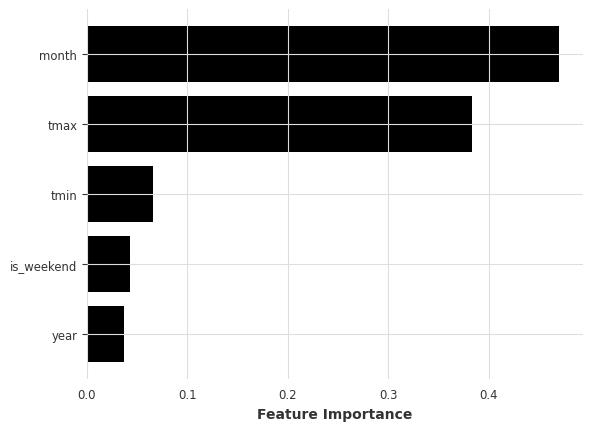

In [245]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, y)
sort = rf.feature_importances_.argsort()
plt.barh(X.columns[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance")

In [246]:
from scipy import stats
coef, p_val = stats.pearsonr(resulting_T_E["presences_tourists"], resulting_T_E["presences_excursionists"])
print(coef, p_val)

0.8590174850048655 1.7332159755302148e-239


# DarTS Timeseries analysis

1- Example taken from the paper

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 166    | train
-------------------------------------------------------------
166       Trainable params
0         Non-trainable params
166       Total params
0.001     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 9/9 [00:00<00:00, 116.76it/s, train_loss=-2.05]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 9/9 [00:00<00:00, 114.87it/s, train_loss=-2.05]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


<Axes: xlabel='Month'>

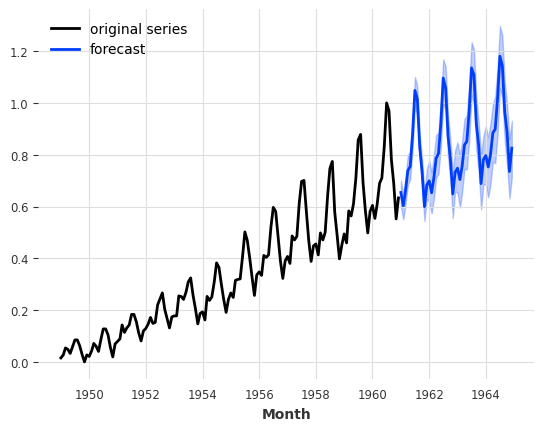

In [306]:
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset 
from darts.dataprocessing.transformers import Scaler 
from darts.models import TCNModel 
from darts.utils.likelihood_models import LaplaceLikelihood as LL 
air = AirPassengersDataset().load() 
milk = MonthlyMilkDataset().load() 
scaler_air, scaler_milk = Scaler(), Scaler() 
air_s = scaler_air.fit_transform(air) 
milk_s = scaler_milk.fit_transform(milk) 
model = TCNModel(input_chunk_length=24, output_chunk_length=12, likelihood=LL()) 
model.fit([air_s, milk_s], epochs=100) 
pred = model.predict(n=48, series=air_s, num_samples=500) 
air_s.plot(label='original series') 
pred.plot(low_quantile=.1, high_quantile=.9, label='forecast')

2- Example from the documentation

In [262]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset
from darts.models import FFT

In [263]:
training_data_T_E = resulting_T_E[["date", "all", "is_weekend", "month", "year", "tmax", "tmin"]]
resulting_ts_df = TimeSeries.from_dataframe(training_data_T_E.reset_index(), 
                                            time_col="date",
                                            value_cols="all")

## Predicting

Automatically detect the seasonal periods, uses the 10 most significant frequencies for
forecasting and expect no global trend to be present in the data:

In [335]:
from darts.datasets import AirPassengersDataset
from darts.models import FFT
# increase the number of frequency and use a polynomial trend of degree 2
model = FFT(
    nr_freqs_to_keep=20,
    trend= "poly",
    trend_poly_degree=2
)
model.fit(resulting_ts_df)
pred = model.predict(300)
#pred.values()

<Axes: xlabel='date'>

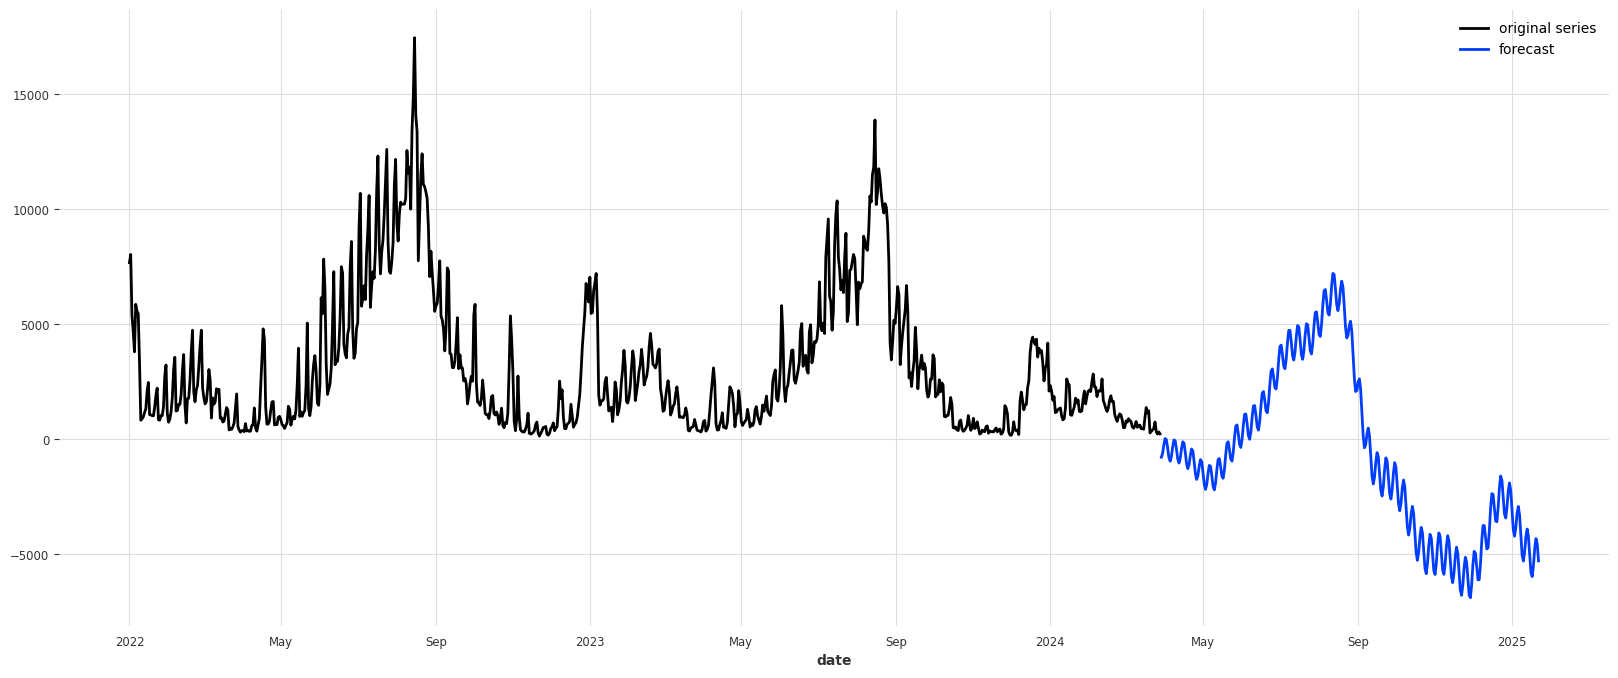

In [336]:
plt.figure(figsize=(20, 8))
resulting_ts_df.plot(label='original series') 
pred.plot(label='forecast') #low_quantile=.1, high_quantile=.9, 

## Detrending

<Axes: xlabel='date'>

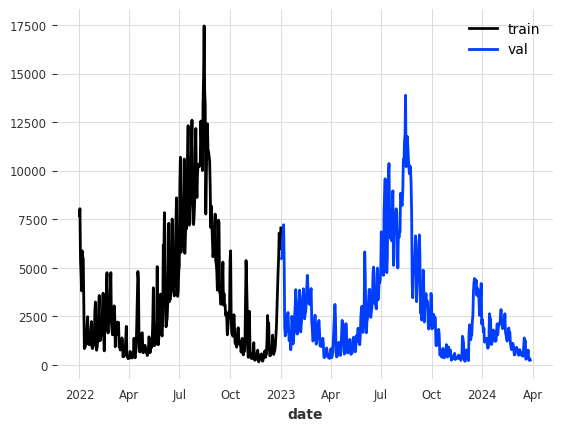

In [311]:
ts_2 = AirPassengersDataset().load()
train, val = resulting_ts_df.split_after(pd.Timestamp("20230101"))
train.plot(label="train")
val.plot(label="val")

### Option 1: No detrending

<Axes: xlabel='date'>

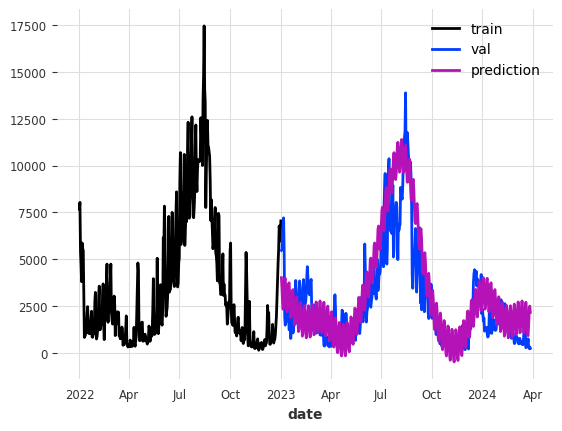

In [313]:
model = FFT()
model.fit(train)
pred_val = model.predict(len(val))
train.plot(label="train")
val.plot(label="val")
pred_val.plot(label="prediction")

### Option 2: With detrending

In [318]:
help(FFT)

Help on class FFT in module darts.models.forecasting.fft:

class FFT(darts.models.forecasting.forecasting_model.LocalForecastingModel)
 |  FFT(*args, **kwargs)
 |  
 |  Method resolution order:
 |      FFT
 |      darts.models.forecasting.forecasting_model.LocalForecastingModel
 |      darts.models.forecasting.forecasting_model.ForecastingModel
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, nr_freqs_to_keep: Optional[int] = 10, required_matches: Optional[set] = None, trend: Optional[str] = None, trend_poly_degree: int = 3)
 |      Fast Fourier Transform Model
 |      
 |      This model performs forecasting on a TimeSeries instance using FFT, subsequent frequency filtering
 |      (controlled by the `nr_freqs_to_keep` argument) and  inverse FFT, combined with the option to detrend
 |      the data (controlled by the `trend` argument) and to crop the training sequence to full seasonal periods
 |      Note that if the training series contai

<Axes: xlabel='date'>

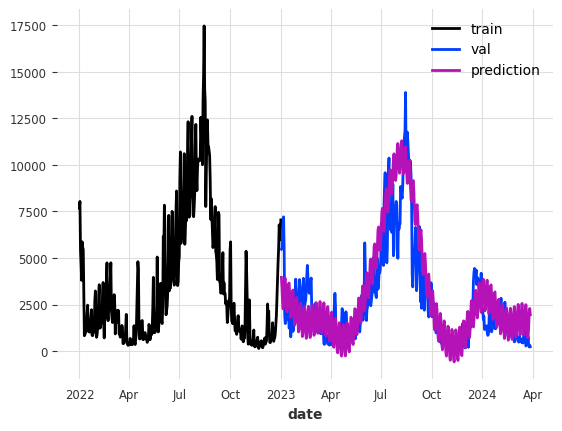

In [339]:
model = FFT(trend="exp")
model.fit(train)
pred_val = model.predict(len(val))
train.plot(label="train")
val.plot(label="val")
pred_val.plot(label="prediction")

# Detrending vodafone visitor attendances

In [254]:
training_data_T_E

,date,all,is_weekend,month,year,tmax,tmin
0,2022-01-01,7680,1,1,2022,0,0.0
1,2022-01-02,8036,1,1,2022,0,0.0
2,2022-01-03,5400,0,1,2022,12,0.0
3,2022-01-04,4693,0,1,2022,0,0.0
4,2022-01-05,3801,0,1,2022,2,0.0
...,...,...,...,...,...,...,...
813,2024-03-24,752,1,3,2024,10,-1.0
814,2024-03-25,325,0,3,2024,13,-3.0
815,2024-03-26,229,0,3,2024,0,0.0
816,2024-03-27,317,0,3,2024,11,7.0


<Axes: xlabel='date'>

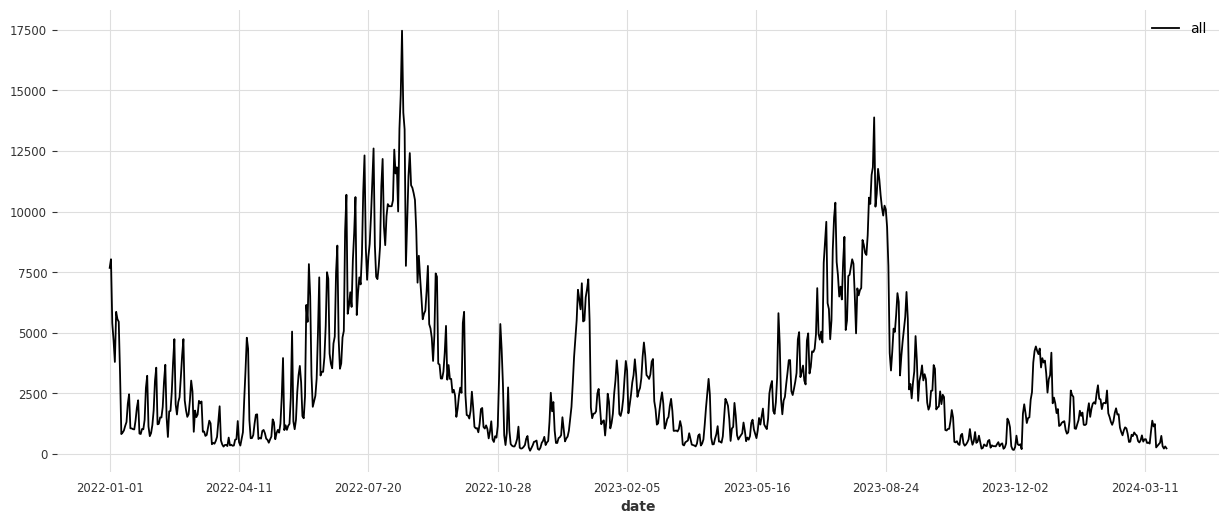

In [292]:
training_data_T_E.plot(x="date", y="all", figsize=(15,6))

<Axes: >

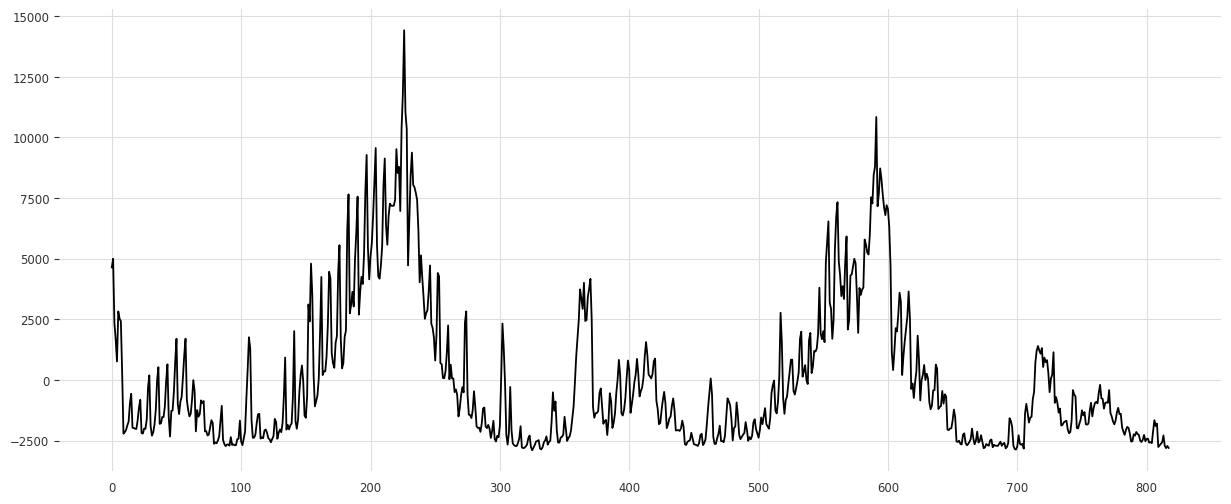

In [289]:
from scipy.signal import detrend
detrended = detrend(training_data_T_E['all'], type='constant')
detrended = pd.Series(detrended, index=training_data_T_E.date)
res_detrended = pd.DataFrame(detrended).reset_index()
res_detrended.rename(columns={0: "value"}, inplace=True)
res_detrended["value"].plot(figsize=(15,6))

## Window operations

<Axes: xlabel='date'>

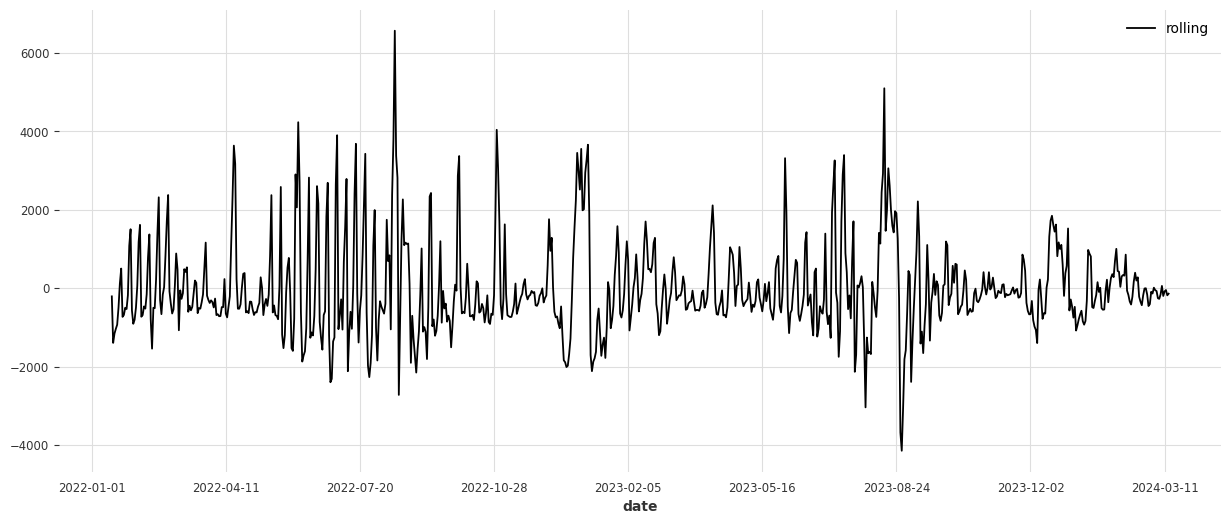

In [305]:
rolling_mean = training_data_T_E['all'].rolling(window=30, center=True).mean()
training_data_T_E["rolling"] = training_data_T_E['all'] - rolling_mean
res_detrended = pd.DataFrame(detrended).reset_index()
training_data_T_E.plot(x="date", y="rolling", figsize=(15,6))

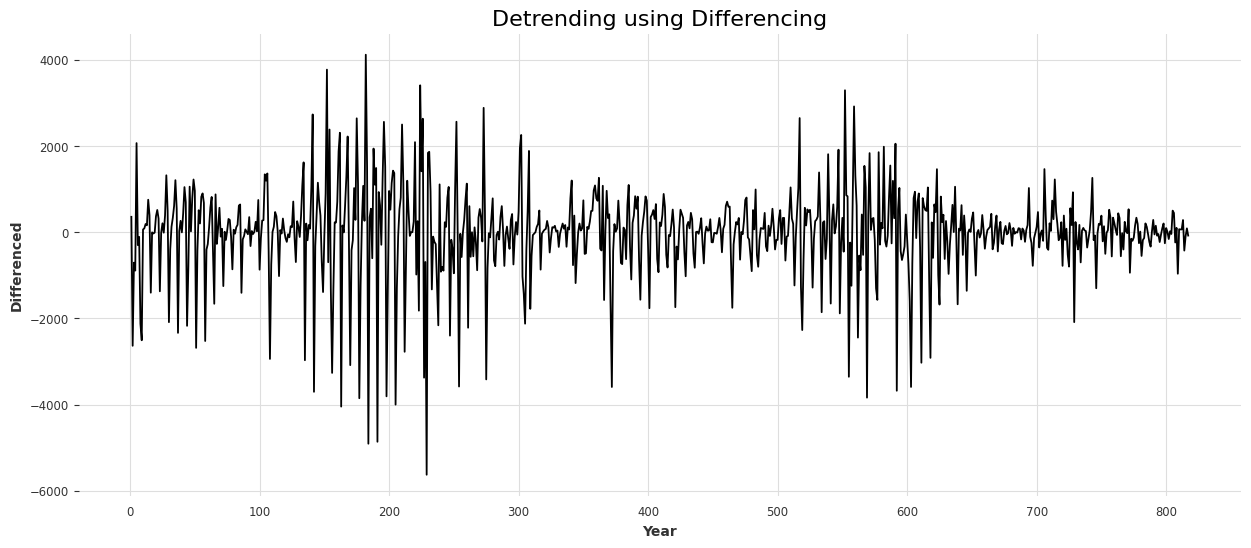

In [295]:
training_data_T_E["diff"] = training_data_T_E["all"].diff()
plt.figure(figsize=(15,6))
plt.plot(training_data_T_E["all"].diff())
plt.title('Detrending using Differencing', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Differenced')
plt.show()

This approach works well for data with a linear trend. If the trend is quadratic (the change in the trend also increases or decreases), then a difference of the already-differenced dataset can be taken, a second level of differencing. This process can be further repeated if needed.

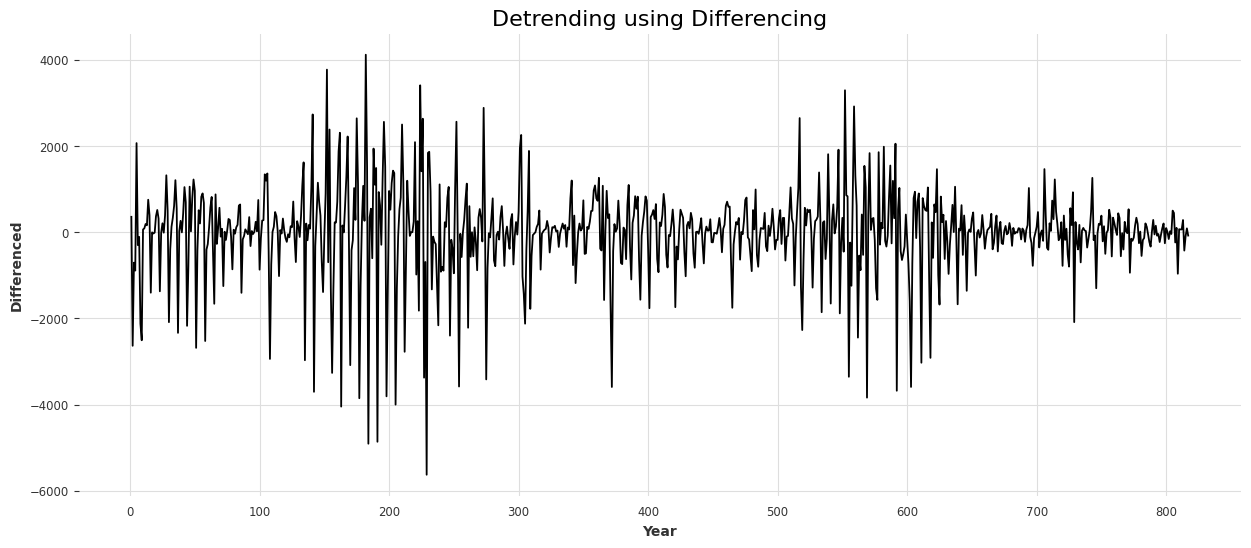

In [294]:
plt.figure(figsize=(15,6))
plt.plot(training_data_T_E["all"].diff())
plt.title('Detrending using Differencing', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Differenced')
plt.show()

# Important Notes
- Confounding factors are variables that influence both the independent and dependent variables, creating a potential spurious association. It’s crucial to identify and control for these variables to prevent bias in statistical analysis.
- By understanding and properly handling confounding factors, we can make more accurate and meaningful inferences from our data, leading to more effective decisions and actions.
- Causal inference methods like uplift modeling, propensity score matching (PSM), and Difference in Differences (DID) are often discussed, but their practical application in real-world work environments, particularly in supporting decision-making, is less frequently explored
- Confounding is a causal concept 